# Next Character Prediction
_Student 902011, Moleri Andrea, a.moleri@campus.unimib.it_

The task is next character prediction in a text. Starting from the provided skeleton of the code:

- properly divide the sequences into training, validation and test. Eventually use an external text for the test to assess the generalization ability
- evaluate the trained model in terms of prediction accuracy
- tune the chunk length to obtain the best performance
- modify the network architecture to obtain the best performance

In aggiunta:

Comunque vuole sia il notebook che la stampa in PDF del notebook 

### Inspecting the Data

The assignment we are about to conduct is based on Dante Alighieri's "The Divine Comedy", which will serve as the dataset for the analysis in question. First, the text is downloaded from my personal GitHub repository, where it is stored in RAW format, in order to avoid compatibility problems for users who access the notebook from Google Colaboratory and do not have the required file saved locally. The text has then been preprocessed by converting all characters to lowercase to ensure uniformity and prevent discrepancies due to case sensitivity. The analysis begins with a basic examination of the text's characteristics, focusing on dimensionality and distribution. The length of the entire text is `558,240` characters. `40` unique characters are identified across the text, which include standard alphabetic characters, punctuation, and whitespace. 

Next, sequences of `30` consecutive characters were extracted from the text by moving through the text with a step size of `3` characters at a time. This means that each sequence of `30` characters overlaps with the previous one by `27` characters, as only `3` new characters are included at each step. This sliding window approach allows for the extraction of subsequences that capture local patterns within the text. In total, `186,070` sequences (`558,240/3`) were generated using this method. These sequences represent sliding windows across the text, which will be useful in a short while for predictive modeling. Further observations shows that the most frequently occurring characters, notably whitespaces and common vowels such as *e*, *a*, and *i*, dominate the data distribution. This frequency distribution is visualized with a bar chart showing the `10` most frequent characters in the text corpus. After the results of this analysis, we can move on to the data preparation phase.

Text Length:
-----------------------------------
558240 characters

Text Sample:
-----------------------------------
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai,
  diro` de l'altre cose ch'i' v'ho scorte.

io non so ben ridir com'i' v'intrai,
  tant'era pien di sonno a quel punto
  che la verace via abbandonai.

ma poi ch'i' fui al pie` d'un colle giunto,
  la` dove terminava quella valle
  che m'avea di paura il cor compunto,

guardai in alto, e vidi le sue spalle
  vestite gia` de' raggi del pianeta
  che mena dritto altrui per ogne calle.

allor fu la paura un poco queta
  che nel lago del cor m'era durata
  la notte ch'i' passai con tanta pieta.

Total Unique Characters:
-----------------------------------
40

Character-to-Index 

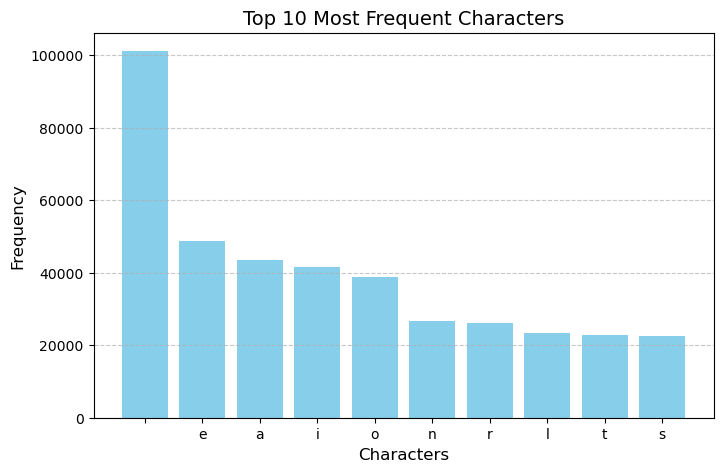

In [69]:
import numpy as np
import requests
from collections import Counter
import matplotlib.pyplot as plt

# URL of the text file containing Dante's "La Divina Commedia"
url = 'https://raw.githubusercontent.com/andreamoleri/AML-Assignments/refs/heads/main/Assignment%204/divina_commedia.txt'

# Download and convert the text to lowercase
text = requests.get(url).text.lower()

# Print the total length of the text in characters
print(f"Text Length:\n{'-' * 35}\n{len(text)} characters")

# Display a selected sample of the text for inspection
print(f"\nText Sample:\n{'-' * 35}\n{text[30:828]}")

# Identify all unique characters in the text and sort them alphabetically
chars = sorted(set(text))

# Print the total number of unique characters
print(f"Total Unique Characters:\n{'-' * 35}\n{len(chars)}")

# Create mappings from characters to indices and vice versa
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

# Display the character-to-index mapping
print(f"\nCharacter-to-Index Mapping:\n{'-' * 35}")
for char, idx in char_indices.items():
    print(f"'{char}': {idx}")

# Define the maximum sequence length and step size for generating text sequences
maxlen, step = 30, 3

# Extract sequences of `maxlen` characters with a step of `step` characters between sequences
sentences = [text[i: i + maxlen] for i in range(0, len(text) - maxlen, step)]

# Store the next character following each sequence
next_chars = [text[i + maxlen] for i in range(0, len(text) - maxlen, step)]

# Print the number of sequences generated
print(f"\nNumber of Sequences Generated:\n{'-' * 35}\n{len(sentences)}")

# Display an example sequence and its corresponding next character
print(f"\nExample of a Sentence:\n{'-' * 35}\nSentence: '{sentences[11]}'\nNext Character: '{next_chars[11]}'")

# Count the frequency of each character in the text
char_counts = Counter(text)

# Sort the characters by their frequency in descending order
sorted_counts = char_counts.most_common()

# Display the top 10 most frequent characters along with their counts
print(f"\nTop 10 Most Frequent Characters:\n{'-' * 35}")
for char, count in sorted_counts[:10]:
    print(f"{repr(char):>5}: {count} occurrences")

# Extract the labels and frequencies of the top 10 characters for visualization
char_labels, char_freqs = zip(*sorted_counts[:10])

# Plot a bar chart of the top 10 most frequent characters
plt.figure(figsize=(8, 5))
plt.bar(char_labels, char_freqs, color='skyblue')
plt.title('Top 10 Most Frequent Characters', fontsize=14)
plt.xlabel('Characters', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Preparing the Data

The preprocessing stage involves preparing sequences from the text data for training, validation, and testing purposes. This phase builds on the previous data inspection results and ensures the sequences are appropriately structured for machine learning models. The initial steps map each unique character into integer indices. As previously discussed, the data is tokenized into sequences of `30` characters, with a step of `3` between each sequence. This choice tries to balance sequence length for context learning while preventing highly overlapping sequences that could lead to redundancies. The text sequences (`sentences`) and their corresponding target characters (`next_chars`) are one-hot encoded into arrays `x` and `y`. Here, each character is transformed into a binary vector representation across `40` unique characters, with `40` being the total number of unique characters identified during the data inspection phase. After encoding, the sequences are split into training, validation, and test subsets. The proportions are set as follows:

- `80%` **for Training**: used to train the machine learning model. As a consequence, the training set is made up of `148,856` sequences with shapes `(30, 40)`
- `10%` **for Validation**: used to tune model hyperparameters and prevent overfitting during training. As a consequence, the validation set is made up of `18,607` sequences with shapes `(30, 40)`
- `10%` **for Testing**: reserved to assess how well the trained model generalizes on unseen data. As a consequence, the test set is made up of `18,607` sequences with shapes `(30, 40)`

In [71]:
# Define the maximum sequence length to be used for training
maxlen = 30  

# Obtain the unique characters in the text and sort them to ensure consistent encoding
chars = sorted(set(text))
# Map each unique character to a unique integer index.
char_indices = {char: i for i, char in enumerate(chars)}
# Map each integer index back to its corresponding character.
indices_char = {i: char for char, i in char_indices.items()}
# Display the total number of unique characters.
print(f"Total characters: {len(chars)}")

# Initialize lists to store input sequences and their corresponding target characters
sentences = []
next_chars = []

# Generate sequences of length `maxlen` with their respective next characters as targets
# Loop with a step of 3 to avoid overly similar sequences
for i in range(0, len(text) - maxlen, 3): 
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])

# Display the total number of sequences generated for training
print(f"Number of sequences generated: {len(sentences)}")

# Initialize the input (x) and output (y) arrays for training with boolean values
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

# One-hot encode the sequences and their respective next characters
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1  # One-hot encode the input sequence characters
    y[i, char_indices[next_chars[i]]] = 1  # One-hot encode the target characters

# Display the shapes of the input and output arrays to verify their structure
print('\nInput (x) and Output (y) shapes:')
print(x.shape)
print(y.shape)

# Define the proportions of data to be used for training, validation, and testing splits
train_split = 0.8
val_split = 0.1  

# Calculate the sizes of the training and validation sets based on the total number of sequences
train_size = int(len(sentences) * train_split)
val_size = int(len(sentences) * val_split)

# Split the data into training, validation, and test sets
x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size]
x_test, y_test = x[train_size + val_size:], y[train_size + val_size:]

# Display the size of each data split to ensure proper partitioning
print('\nData split:')
print(f'Training set: {x_train.shape}, {y_train.shape}')
print(f'Validation set: {x_val.shape}, {y_val.shape}')
print(f'Test set: {x_test.shape}, {y_test.shape}')

Total characters: 40
Number of sequences generated: 186070

Input (x) and Output (y) shapes:
(186070, 30, 40)
(186070, 40)

Data split:
Training set: (148856, 30, 40), (148856, 40)
Validation set: (18607, 30, 40), (18607, 40)
Test set: (18607, 30, 40), (18607, 40)


In [50]:
## Building the Models

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Model 1: Baseline model
print("Building Model 1...")
chunk_length_1 = 30  # Baseline chunk length
x_train_1 = x_train[:, :chunk_length_1, :]  # Adjust training data
x_val_1 = x_val[:, :chunk_length_1, :]
x_test_1 = x_test[:, :chunk_length_1, :]

model_1 = Sequential()
model_1.add(LSTM(128, input_shape=(chunk_length_1, len(chars))))  # Single LSTM layer
model_1.add(Dense(len(chars), activation='softmax'))  # Output layer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_1.summary()

# Model 2: Improved model with increased chunk length and layers
print("\nBuilding Model 2...")
chunk_length_2 = 40  # Increased chunk length
x_train_2 = x_train[:, :chunk_length_2, :]  # Adjust training data
x_val_2 = x_val[:, :chunk_length_2, :]
x_test_2 = x_test[:, :chunk_length_2, :]

model_2 = Sequential()
model_2.add(LSTM(256, input_shape=(chunk_length_2, len(chars)), return_sequences=True))  # Stacked LSTM
model_2.add(Dropout(0.2))  # Regularization
model_2.add(LSTM(128))  # Second LSTM layer
model_2.add(Dense(len(chars), activation='softmax'))  # Output layer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)  # Reduced learning rate for stability
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_2.summary()

# Model 3: Advanced model with further increased chunk length
print("\nBuilding Model 3...")
chunk_length_3 = 50  # Further increased chunk length
x_train_3 = x_train[:, :chunk_length_3, :]  # Adjust training data
x_val_3 = x_val[:, :chunk_length_3, :]
x_test_3 = x_test[:, :chunk_length_3, :]

model_2 = Sequential()
model_2.add(LSTM(256, input_shape=(chunk_length_2, len(chars)), return_sequences=True))  # Stacked LSTM
model_2.add(Dropout(0.3))  # Regularization
model_2.add(LSTM(128))  # Second LSTM layer
model_2.add(Dense(len(chars), activation='softmax'))  # Output layer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)  # Reduced learning rate for stability
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_2.summary()

Building Model 1...
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 128)               86528     
                                                                 
 dense_16 (Dense)            (None, 40)                5160      
                                                                 
Total params: 91688 (358.16 KB)
Trainable params: 91688 (358.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Building Model 2...
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 40, 256)           304128    
                                                                 
 dropout_13 (Dropout)        (None, 40, 256)           0         
                 

Evaluating Model 1...
Training Model 1...
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.7074 - accuracy: 0.2261
******* Epoch: 1 ********
***** Starting sentence *****
men caro,
  se oltre promessio
*****************************
***** Generated text *****
men caro,
  se oltre promessio di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di se di 

73/73 [==============================] - 75s 1s/step - loss: 2.7074 - accuracy: 0.2261 - val_loss: 2.2037 - val_accuracy: 0.3208
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 2.1131 - accuracy: 0.3414
******* Epoch: 2 ********
***** Starting sentence *****
eare e ne

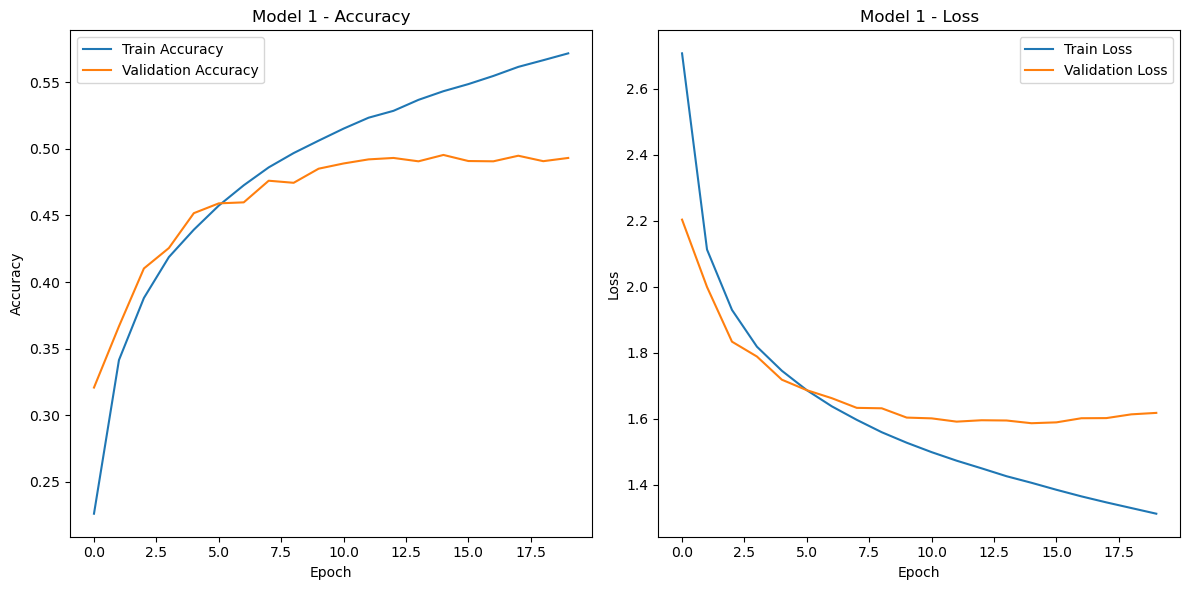


Evaluating Model 2...
Training Model 2...
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.9836 - accuracy: 0.1798
******* Epoch: 1 ********
***** Starting sentence *****
>>.

poi l'addentar con piu` di cento ra
*****************************
***** Generated text *****
>>.

poi l'addentar con piu` di cento ra a e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e

73/73 [==============================] - 223s 3s/step - loss: 2.9836 - accuracy: 0.1798 - val_loss: 2.7641 - val_accuracy: 0.2068
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 2.5179 - accuracy: 0.2502
******* Epoch: 2 ********
***** Starting se

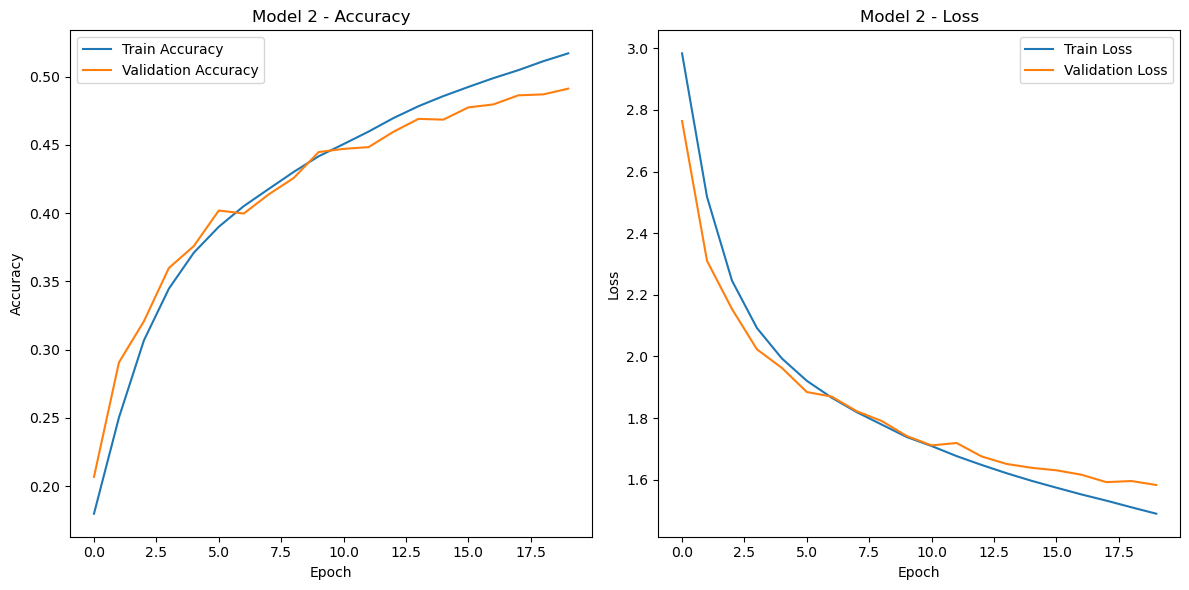


Evaluating Model 3...
Training Model 3...
Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 2.1290 - accuracy: 0.3423
******* Epoch: 1 ********
***** Starting sentence *****
 la testa di mio figlio fu, dal quale
  cominciar 
*****************************
***** Generated text *****
 la testa di mio figlio fu, dal quale
  cominciar che la sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  che la sur sur sur sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  che la sur sur sur sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  che la sur sur sur sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  che la sur sur sur sur sur sur sur sunta
  che la sur sur sur sur sur sur sura,
  ch

73/73 [==============================] - 653s 9s/step - loss: 2.1290 - accuracy: 0.3423 - val_loss: 2.0721 - val_accuracy: 0.3585
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 2.0634 - accuracy: 0.3584
******* Epoch: 2 ******

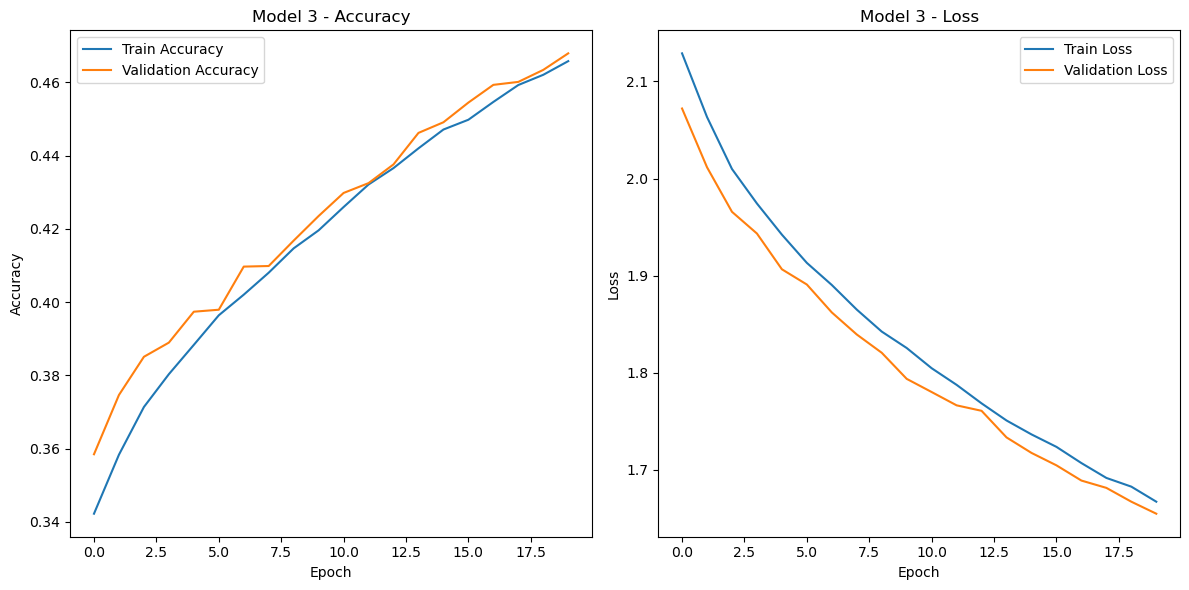

(1.6652802228927612, 0.4713279902935028)

In [51]:
## Train and Evaluate the Models

import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback
import sys

# Helper function to test text generation after each epoch
def testAfterEpoch(model, text, char_indices, indices_char, maxlen, epoch, _):
    print()
    print(f"******* Epoch: {epoch+1} ********")
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence

    print("***** Starting sentence *****")
    print(sentence)
    print("*****************************")

    for _ in range(400):  # Generate 400 characters
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.argmax(preds)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char
        generated += next_char

    print("***** Generated text *****")
    print(generated)
    print()

# Function to prepare data for a given chunk length
def prepare_data_for_chunk_length(text, chars, char_indices, maxlen, step=3):
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
    y = np.zeros((len(sentences), len(chars)), dtype=bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

# Function to train a model and evaluate its performance
def train_and_evaluate(model, x, y, text, char_indices, indices_char, maxlen, batch_size, epochs, model_name):
    # Split the data into training, validation, and test sets
    split_train = int(len(x) * 0.8)
    split_val = int(len(x) * 0.9)
    x_train, y_train = x[:split_train], y[:split_train]
    x_val, y_val = x[split_train:split_val], y[split_train:split_val]
    x_test, y_test = x[split_val:], y[split_val:]

    print(f"Training {model_name}...")
    print_callback = LambdaCallback(on_epoch_end=lambda epoch, _: testAfterEpoch(model, text, char_indices, indices_char, maxlen, epoch, _))
    
    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[print_callback],
        verbose=1
    )
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return test_loss, test_accuracy

# Train and evaluate each model
batch_size = 2048
epochs = 20

# Model 1 - Chunk length = 30
x_1, y_1 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=30)
print("Evaluating Model 1...")
train_and_evaluate(model_1, x_1, y_1, text, char_indices, indices_char, 30, batch_size, epochs, "Model 1")

# Model 2 - Chunk length = 50
x_2, y_2 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=40)
print("\nEvaluating Model 2...")
train_and_evaluate(model_2, x_2, y_2, text, char_indices, indices_char, 40, batch_size, epochs, "Model 2")

# Model 3 - Chunk length = 70
x_3, y_3 = prepare_data_for_chunk_length(text, chars, char_indices, maxlen=50)
print("\nEvaluating Model 3...")
train_and_evaluate(model_3, x_3, y_3, text, char_indices, indices_char, 50, batch_size, epochs, "Model 3")


In [30]:
import sys
def testAfterEpoch(epoch, _):
  print()
  print()
  print('******* Epoch: %d ********' % (epoch+1))
  start_index = random.randint(0, len(text)-maxlen-1)

  generated = ''
  sentence = text[start_index :  start_index + maxlen]
  generated = generated + sentence

  print('***** starting sentence *****')
  print(sentence)
  print('*****************************')
  sys.stdout.write(generated)

  for i in range(400):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
  print()



In [31]:
print_callback = LambdaCallback(on_epoch_end=testAfterEpoch)

In [32]:
model.fit(x, y,
          batch_size = 2048,
          epochs = 20,
          callbacks = [print_callback])

Epoch 1/20
91/91 [==============================] - ETA: 0s - loss: 2.6218

******* Epoch: 1 ********
***** starting sentence *****
olui che tutto 'l mondo alluma
*****************************
olui che tutto 'l mondo alluma la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la 
91/91 [==============================] - 75s 806ms/step - loss: 2.6218
Epoch 2/20
91/91 [==============================] - ETA: 0s - loss: 2.0454

******* Epoch: 2 ********
***** starting sentence *****
e o lievemente o forte>>.

que
*****************************
e o lievemente o forte>>.

quen la per la ser con per la per la per la per la per la per la per la per la per la